In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import StackingRegressor

In [5]:
df = pd.read_csv('wfp_food_prices_database.csv') # dataset terlalu besar untuk diupload ke github maka berikut adalah link dari dataset tersebut https://www.kaggle.com/datasets/salehahmedrony/global-food-prices

C:\Users\Acer\AppData\Local\Temp\ipykernel_22256\3850158830.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('wfp_food_prices_database.csv')


In [6]:
# adm0_id: country id
# adm0_name: country name
# adm1_id: locality id
# adm1_name: locality name
# mkt_id: market id
# mkt_name: market name
# cm_id: commodity purchase id
# cm_name: commodity purchased
# cur_id: currency id
# cur_name: name of currency
# pt_id: market type id
# pt_name: market type (Retail/Wholesale/Producer/Farm Gate)
# um_id: measurement id
# um_name: unit of goods measurement
# mp_month: month recorded
# mp_year: year recorded
# *mp_price: price paid
# mp_commoditysource: Source supplying price information

In [7]:
df.drop(columns=[col for col in df.columns if col.endswith('_id')], inplace=True)
df.rename(columns={
    'adm0_name': "Country", 'adm1_name': "Region", 'mkt_name': "Market",
    'cm_name': "Commodity", 'cur_name':"Currency", 'pt_name': "Market_type",
    'um_name': "Quantity", 'mp_month': "Month", 'mp_year': "Year",
    'mp_price': "Price", 'mp_commoditysource': "Source"
}, inplace=True)

In [9]:
df_indonesia = df[df['Country'] == 'Indonesia']


In [10]:
df_indonesia['Date'] = pd.to_datetime(df_indonesia['Year'].astype(str) + '-' + df_indonesia['Month'].astype(str), format='%Y-%m')

C:\Users\Acer\AppData\Local\Temp\ipykernel_22256\2256427747.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_indonesia['Date'] = pd.to_datetime(df_indonesia['Year'].astype(str) + '-' + df_indonesia['Month'].astype(str), format='%Y-%m')


In [11]:
keyword_map = {'rice': 'Rice', 'oil': 'Oil'}
df_indonesia['Commodity_f'] = df_indonesia['Commodity'].apply(lambda x: next((v for k, v in keyword_map.items() if k in x.lower()), None))


C:\Users\Acer\AppData\Local\Temp\ipykernel_22256\1139476865.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_indonesia['Commodity_f'] = df_indonesia['Commodity'].apply(lambda x: next((v for k, v in keyword_map.items() if k in x.lower()), None))


In [12]:
selected_commodities = ['Rice', 'Oil']
filtered_df = df_indonesia[df_indonesia['Commodity_f'].isin(selected_commodities)]

C:\Users\Acer\AppData\Local\Temp\ipykernel_22256\3038641037.py:1: FutureWarning: The provided callable <function mean at 0x000001B5DFD0A8E0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot_table = pd.pivot_table(filtered_df, values='Price', index=['Country'], columns=['Commodity_f'], aggfunc=np.mean)


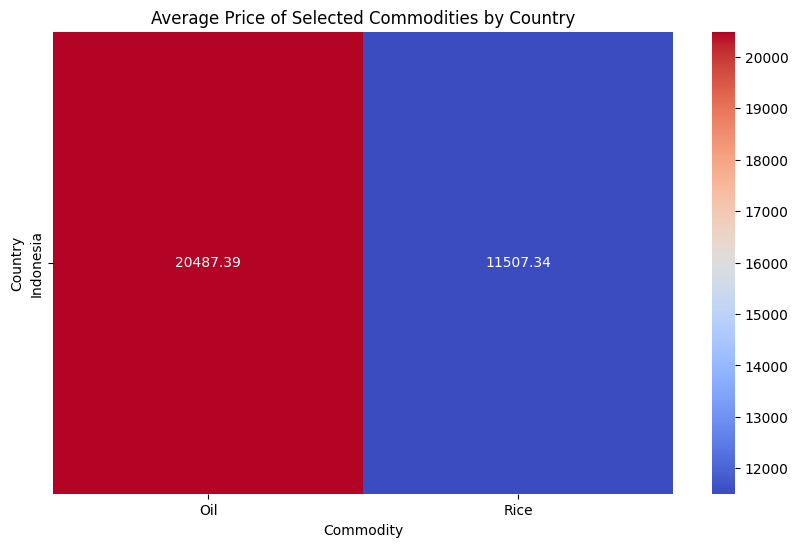

In [13]:
pivot_table = pd.pivot_table(filtered_df, values='Price', index=['Country'], columns=['Commodity_f'], aggfunc=np.mean)
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Average Price of Selected Commodities by Country')
plt.xlabel('Commodity')
plt.ylabel('Country')
plt.show()

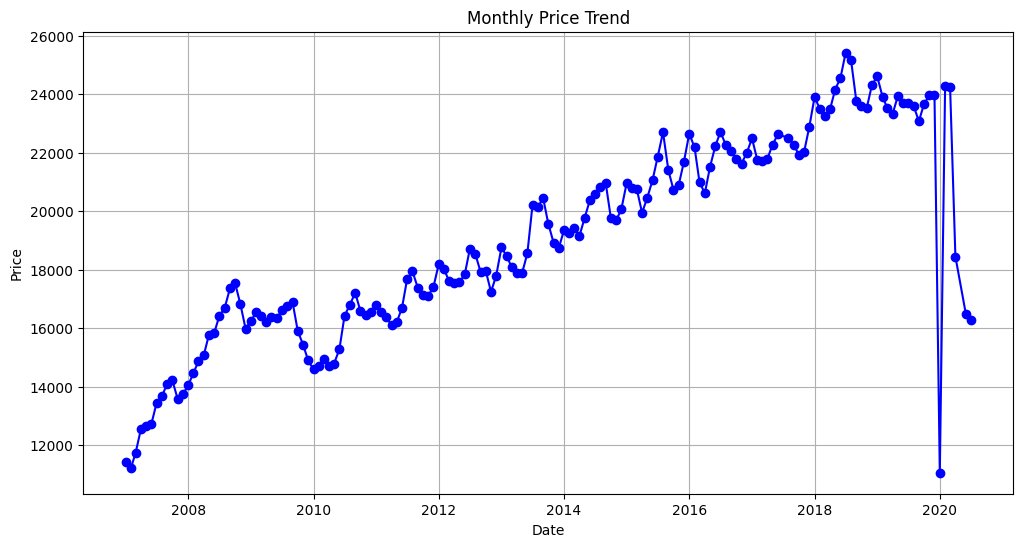

In [14]:
monthly_prices = filtered_df.groupby('Date')['Price'].mean()
plt.figure(figsize=(12, 6))
plt.plot(monthly_prices.index, monthly_prices.values, marker='o', linestyle='-', color='b')
plt.title('Monthly Price Trend')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()


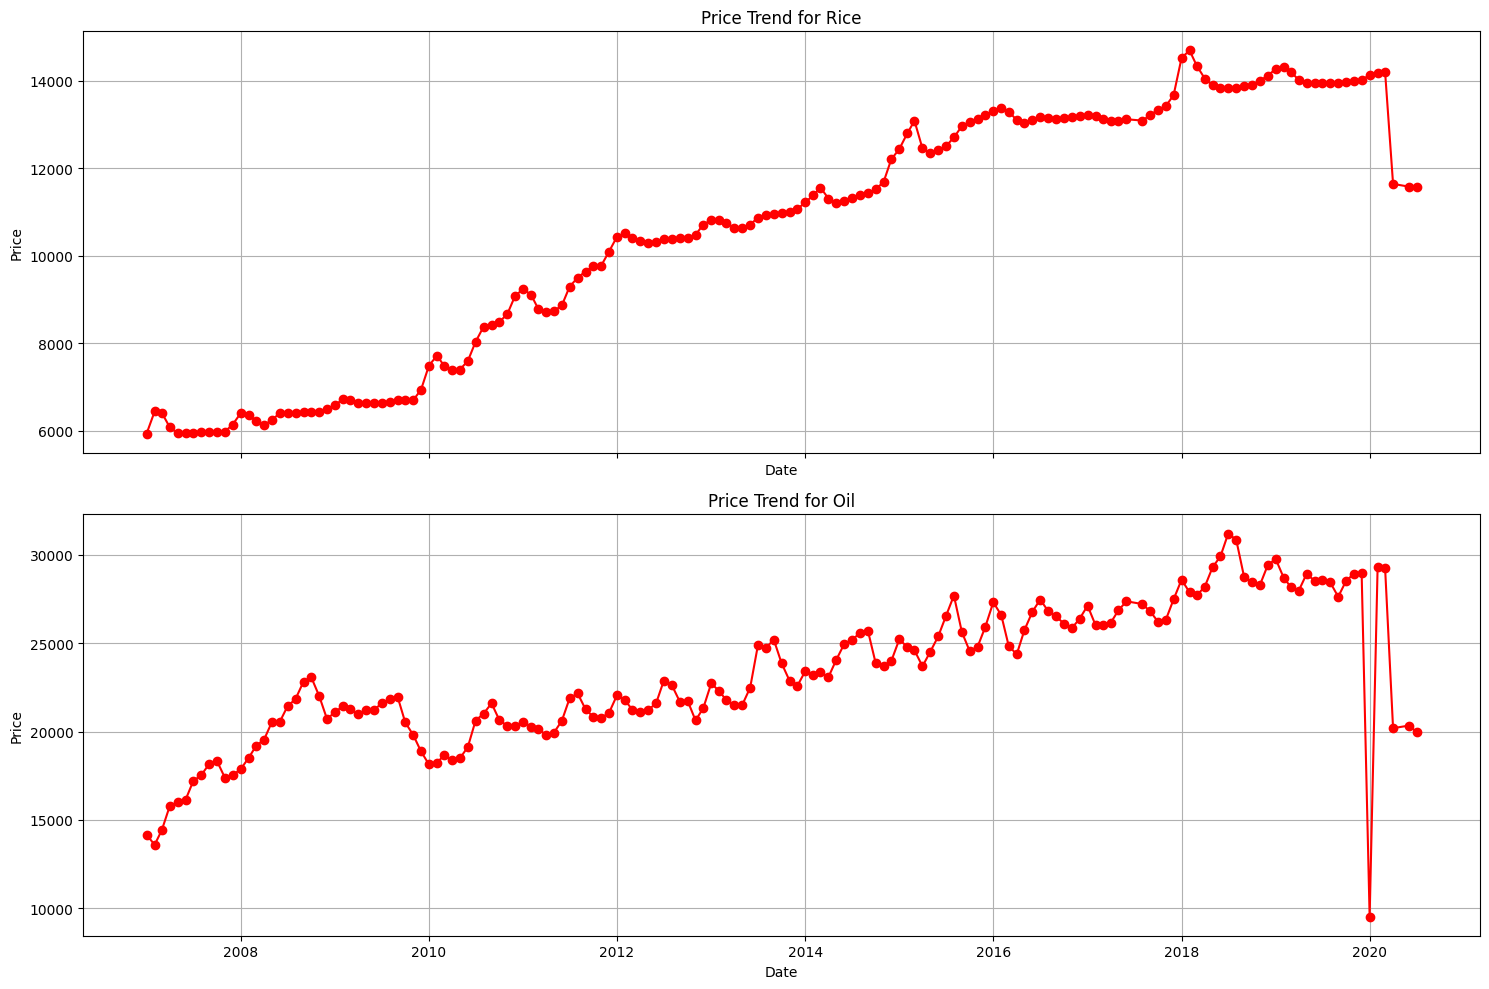

In [15]:
commodities = filtered_df['Commodity_f'].unique()
fig, axs = plt.subplots(len(commodities), 1, figsize=(15, 5 * len(commodities)), sharex=True)
for i, commodity in enumerate(commodities):
    commodity_data = filtered_df[filtered_df['Commodity_f'] == commodity].groupby('Date')['Price'].mean()
    axs[i].plot(commodity_data.index, commodity_data.values, marker='o', linestyle='-', color='r')
    axs[i].set_title(f'Price Trend for {commodity}')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Price')
    axs[i].grid(True)
fig.tight_layout()
plt.show()


In [16]:
def prepare_data_for_forecasting(data, commodity_name):
    df_commodity = data[data['Commodity_f'] == commodity_name].copy()
    df_commodity['Date'] = df_commodity['Date'].map(pd.Timestamp.toordinal)
    X = df_commodity[['Date']]
    y = df_commodity['Price']
    return train_test_split(X, y, test_size=0.2, shuffle=False)


In [17]:
def forecast_commodity_price(data, commodity_name):
    X_train, X_test, y_train, y_test = prepare_data_for_forecasting(data, commodity_name)
    
    # Definisikan model dasar
    rf = RandomForestRegressor(random_state=42)
    lr = LinearRegression()
    
    # Definisikan model ensemble stacking
    estimators = [('rf', rf), ('lr', lr)]
    stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
    
    # Latih model stacking
    stacking_regressor.fit(X_train, y_train)
    
    # Buat prediksi
    y_pred = stacking_regressor.predict(X_test)
    
    # Evaluasi model
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Error Kuadrat Rata-rata untuk {commodity_name}: {mse}')
    print(f'Error Mutlak Rata-rata untuk {commodity_name}: {mae}')
    
    # Ramalkan untuk 60 bulan ke depan (5 tahun)
    last_date = X_train['Date'].max()
    future_dates = np.array([last_date + i for i in range(1, 61)]).reshape(-1, 1)
    forecast = stacking_regressor.predict(future_dates)
    return forecast

In [18]:
rice_forecast = forecast_commodity_price(filtered_df, 'Rice')
oil_forecast = forecast_commodity_price(filtered_df, 'Oil')


Mean Squared Error for Rice: 2117445.346160102
Mean Absolute Error for Rice: 1190.173493951709


c:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Mean Squared Error for Oil: 97570691.14148396
Mean Absolute Error for Oil: 8374.183355486248


c:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [19]:
rice_yearly_forecast = rice_forecast.reshape(-1, 12).mean(axis=1)
oil_yearly_forecast = oil_forecast.reshape(-1, 12).mean(axis=1)

In [20]:
print('Rice price forecast (per year):')
for i, price in enumerate(rice_yearly_forecast):
    print(f"Year {i+1}: {price:.2f}")
print('\n')

print('Oil price forecast (per year):')
for i, price in enumerate(oil_yearly_forecast):
    print(f"Year {i+1}: {price:.2f}")

Rice price forecast (per year):
Year 1: 11648.90
Year 2: 11623.49
Year 3: 11598.08
Year 4: 11572.67
Year 5: 11547.26


Oil price forecast (per year):
Year 1: 20715.48
Year 2: 20714.87
Year 3: 20714.26
Year 4: 20713.65
Year 5: 20713.04
